# Regression Analysis
This notebook performs regression analysis following a structured approach:

1. **Preprocessing**
   - Handle missing values and outliers
   - Scale features using standardization or normalization
   - Perform feature selection

2. **Build and Evaluate Models**
   - Train a Linear Regression model
   - Evaluate using R² Score and RMSE
   - Perform K-Fold Cross-Validation

3. **Enhance the Model**
   - Experiment with feature selection techniques
   - Visualize results (e.g., feature importance, residual plots)

4. **Creativity**
   - Try advanced models (e.g., Ridge, Lasso, Polynomial)
   - Create insightful visualizations or optimize hyperparameters
   - Use the SHAP package for reporting

In [6]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Step 1: Preprocessing
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Load the dataset
house_data = pd.read_csv('/Users/nimishmathur/Desktop/synthetic_house_prices.csv')

# Define features and target
X = house_data.drop(columns=['SalePrice'])
y = house_data['SalePrice']

# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing steps
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [3]:
# Step 2: Build and Evaluate Models
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')

print(f"R² Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print("Cross-Validation Scores:", cv_scores)

R² Score: 0.99
RMSE: 21458.66
Cross-Validation Scores: [0.99187153 0.99275931 0.99240204 0.99352375 0.99055597]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
# Step 3: Enhance the Model
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Feature selection with RFE
ridge_model = Ridge(alpha=1.0)
rfe = RFE(estimator=ridge_model, n_features_to_select=10)
pipeline_with_rfe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', rfe),
    ('model', ridge_model)
])

pipeline_with_rfe.fit(X_train, y_train)
y_pred_rfe = pipeline_with_rfe.predict(X_test)
r2_rfe = r2_score(y_test, y_pred_rfe)
rmse_rfe = mean_squared_error(y_test, y_pred_rfe, squared=False)

print(f"R² Score with RFE: {r2_rfe:.2f}")
print(f"RMSE with RFE: {rmse_rfe:.2f}")

R² Score with RFE: 0.99
RMSE with RFE: 21881.84


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


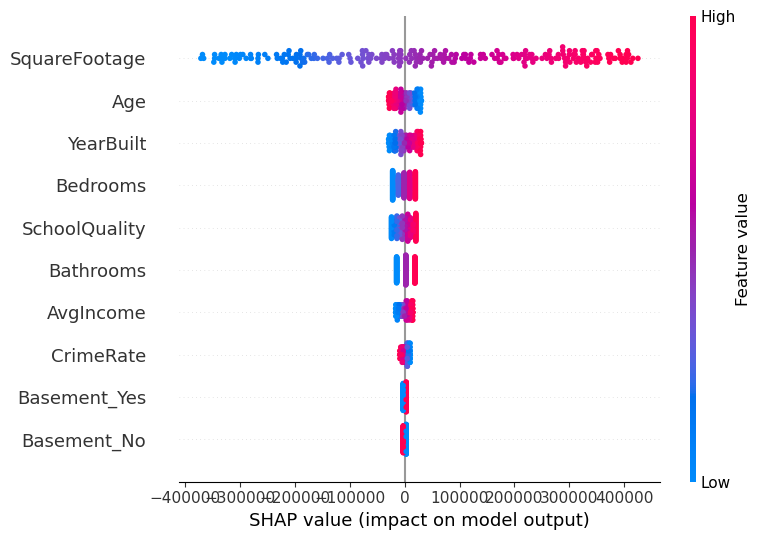

In [18]:
# Step 4: Creativity - Use SHAP Package for Reporting

import numpy as np

# 4.1: Extract feature names after preprocessing
numerical_feature_names = numerical_cols
categorical_feature_names = list(
    pipeline_with_rfe.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
)
all_feature_names = numerical_feature_names + categorical_feature_names

# 4.2: Preprocess the training and test datasets
X_train_preprocessed = pipeline_with_rfe.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = pipeline_with_rfe.named_steps['preprocessor'].transform(X_test)

# 4.3: Select features based on RFE output
selected_features_mask = pipeline_with_rfe.named_steps['feature_selector'].support_
selected_features_preprocessed = X_train_preprocessed[:, selected_features_mask]
selected_test_features_preprocessed = X_test_preprocessed[:, selected_features_mask]

# 4.4: Use SHAP to interpret the model's predictions
explainer = shap.Explainer(pipeline_with_rfe.named_steps['model'], selected_features_preprocessed)
shap_values = explainer(selected_test_features_preprocessed)

# 4.5: Visualize the impact of features using SHAP summary plot
shap.summary_plot(shap_values, feature_names=np.array(all_feature_names)[selected_features_mask])
